<a href="https://colab.research.google.com/github/bingyulab/NumericalPDE/blob/main/Numerical_PDE_homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A first finite element code

In this notebook we will develop a one-dimensional finite Galerkin finite
element code.

```{note}
This notebook is incomplete and will be completed as an exercise in class.
```

## Basic algorithm

Recall that using the notions in {doc}`part1` and during class we derived the
following expressions for the entries of the finite element stiffness matrix
$\mathbf{K}$ and load vector $\mathbf{f}$

$$
\begin{align}
K_{ij} &:= \sum_{K \in \mathcal{T}_h} \int_{K} \nabla \phi_i \cdot \nabla \phi_j \; \mathrm{d}x, \\
f_{j} &:= \sum_{K \in \mathcal{T}_h} \int_{K} f \phi_j \; \mathrm{d}x.
\end{align}
$$

Instead of calculating each entry of $K_{ij}$ we discussed that the most
straightforward way to *assemble* the stiffness matrix is to:
1. Loop over the global cells $K$ of the mesh $\mathcal{T}_h$.
2. Calculate the cell local contribution $\mathbf{K}_K \in \mathbb{R}^{2
\times 2}$.
3. Determine which pair of finite element basis functions are active on the
   cell.
4. *Assemble* (add) the cell local contribution to the stiffness matrix at
   the location of the active basis functions.

The load vector assembly follows similarly.



### Exercise 1

For a general cell $K$ derive an explicit symbolic expression for the cell
local contribution $\mathbf{K}_K \in \mathbb{R}^{2 \times 2}$ in terms of
$h$. Use the local-to-global mapping approach shown in class.

*Answer*


1. **Reference element**
   $$
   \hat K = [0,1],
   \quad
   \hat\phi_0(\hat x)=1-\hat x,\quad \hat\phi_1(\hat x)=\hat x.
   $$
   Their derivatives on $\hat K$ are
   $$
   \frac{d\hat\phi_0}{d\hat x}=-1,
   \quad
   \frac{d\hat\phi_1}{d\hat x}=+1.
   $$
2. **Affine map to physical cell**
   $$
   x = a + h\,\hat x,\qquad h=b-a.
   $$
   Hence
   $$
   \frac{d}{dx}
   =\frac{1}{h}\,\frac{d}{d\hat x},
   $$
   and the physical basis-function derivatives are
   $$
   \phi_i'(x)
   =\frac{d\hat\phi_i}{d\hat x}\;\frac{1}{h}
   =\begin{cases}
   -\tfrac1h,&i=0,\\[6pt]
    \tfrac1h,&i=1.
   \end{cases}
   $$
3. **Local stiffness entries**  
   On cell $K$, the $(i,j)$ entry is

   $$
   (\mathbf K_K)_{ij}
   =\int_K \phi_i'(x)\,\phi_j'(x)\,dx
   =\int_0^1\Bigl(\tfrac1h\,\tfrac{d\hat\phi_i}{d\hat x}\Bigr)
                \Bigl(\tfrac1h\,\tfrac{d\hat\phi_j}{d\hat x}\Bigr)
                \;h\,d\hat x
   =\frac1h\int_0^1\frac{d\hat\phi_i}{d\hat x}\,\frac{d\hat\phi_j}{d\hat x}\,d\hat x.
   $$

   Since $\int_0^1 1\cdot1\,d\hat x=1,\;\int_0^1 1\cdot(-1)\,d\hat x=-1$, etc., one finds

   $$
   \mathbf K_K
   =\frac1h
   \begin{bmatrix}
     \displaystyle\int_0^1(-1)(-1)\,d\hat x &
     \displaystyle\int_0^1(-1)(+1)\,d\hat x \\[8pt]
     \displaystyle\int_0^1(+1)(-1)\,d\hat x &
     \displaystyle\int_0^1(+1)(+1)\,d\hat x
   \end{bmatrix}
   =\frac1h
   \begin{bmatrix}
     1 & -1\\
    -1 &  1
   \end{bmatrix}.
   $$

4. **Final answer**  
   On any cell $K=[a,b]$ of length $h=b-a$,

   $$
   \boxed{
   \mathbf K_K
   =\int_K
      \begin{bmatrix}
        \phi_0'\phi_0' & \phi_0'\phi_1'\\
        \phi_1'\phi_0' & \phi_1'\phi_1'
      \end{bmatrix}
    dx
   =\frac1{b-a}
   \begin{bmatrix}
     1 & -1\\
    -1 &  1
   \end{bmatrix}.
   }
   $$
5. **Different way**  
In reference coordinates:
$$
\dot{K}_K = \frac{1}{h} \int_{\hat{K}} \frac{d\hat{\phi}_i}{d\hat{x}} \frac{d\hat{\phi}_j}{d\hat{x}} \, d\hat{x}
$$
use the change of variables:
- $dx = h \, d\hat{x}$ (so $d\hat{x} = \frac{1}{h} dx$)
- and $\phi_i'(x) = \frac{1}{h} \frac{d\hat{\phi}_i}{d\hat{x}}$

So the full transformation becomes:

$$
\begin{align}
 & \int_K \phi_i'(x) \phi_j'(x) \, dx
= \int_0^1 \left(\frac{1}{h} \frac{d\hat{\phi}_i}{d\hat{x}}\right)\left(\frac{1}{h} \frac{d\hat{\phi}_j}{d\hat{x}}\right) h \, d\hat{x}
 \\
 & = \frac{1}{h} \int_0^1 \frac{d\hat{\phi}_i}{d\hat{x}} \frac{d\hat{\phi}_j}{d\hat{x}} \, d\hat{x}
\end{align}
$$
which yields same results.



### Exercise 2

Complete the function `cell_stiffness` which returns the stiffness matrix for
a cell with vertices $a$ and $b$ with $b > a$.

In [1]:
import numpy as np
import numpy.typing as npt
import scipy.sparse
import matplotlib.pyplot as plt
from typing import NamedTuple, Callable


def cell_stiffness(a: float, b: float) -> npt.NDArray[np.float64]:
    """Calculate the stiffness matrix contribution for a cell with vertices a and b.

    Args:
        a: Position of first vertex.
        b: Position of second vertex.

    Return:
        The stiffness matrix contribution for the cell.
    """
    assert b > a
    h = b - a
    return (1 / h) * np.array([[1, -1], [-1, 1]], dtype=np.float64)

stiffness_matrix = cell_stiffness(*[0.0, 1.0])
assert stiffness_matrix.shape == (2, 2)
print(f"stiffness matrix: \n", stiffness_matrix)

stiffness matrix: 
 [[ 1. -1.]
 [-1.  1.]]



## Mesh

The mesh will be composed of two data structures:
1. the *geometry* which will contain the positions of the vertices of the
mesh. The index on the first dimension (rows) is the mesh vertex number. The
index on the second dimension (columns) of the geometry is the related to the
coordinate index.
2. the *topology*, which will contain the cell-to-vertex connectivity. The
index on the first dimension (rows) is the cell number. The index on the
second dimension (columns) are the indices of the vertices of the cell.

Consider the case when we want to create a mesh with $N = 4$ cells. Here the
geometry will be a two-dimensional numpy array containing

$$
\text{geometry} =
\begin{bmatrix}
0.0 \\
0.25 \\
0.5 \\
0.75 \\
1.0
\end{bmatrix},
$$

and the topology a two-dimensional numpy array containing

$$
\text{topology} =
\begin{bmatrix}
0 & 1 \\
1 & 2 \\
2 & 3 \\
3 & 4
\end{bmatrix}.
$$

### Exercise 3

Generalise the function `create_unit_interval_mesh` to arbitrary input
`num_cells`.

```{note}
To avoid object-oriented programming, but to still keep the code tidy, we
will use Python's namedtuple feature which allows tuples to have *named
fields*.
```


In [2]:
Mesh = NamedTuple(
    "Mesh", (("geometry", npt.NDArray[np.float64]), ("topology", npt.NDArray[np.int32]))
)


def create_unit_interval_mesh(num_cells: int) -> Mesh:
    """
    Generate a 1D uniform mesh on the unit interval.

    Args:
        num_cells: Number of cells.

    Returns:
        A 1D uniform mesh on the unit interval.
    """
    geometry = np.linspace(0.0, 1.0, num_cells + 1).reshape(-1, 1)
    # topology = np.array([[i, i + 1] for i in range(num_cells)], dtype=np.int32)
    # Each cell connects vertex i to i+1
    topology = np.vstack([np.arange(num_cells, dtype=np.int32),
                          np.arange(1, num_cells + 1, dtype=np.int32)]).T
    return Mesh(geometry=geometry, topology=topology)


num_cells = 32
c = 1.0 * np.pi
mesh = create_unit_interval_mesh(num_cells)

if num_cells == 4:
    print(f"Mesh: {mesh}")
    assert np.all(np.isclose(mesh.geometry, [[0.0], [0.25], [0.5], [0.75], [1.0]]))
    assert np.all(np.isclose(mesh.topology, [[0, 1], [1, 2], [2, 3], [3, 4]]))

For example, for the second cell we can get the connected global vertices using

In [3]:
print(mesh.topology[1])

[1 2]


and the position of the vertices using

In [4]:
print(mesh.geometry[mesh.topology[1]])

[[0.03125]
 [0.0625 ]]


and assemble the local stiffness matrix contribution. The `*` unpacks the
entries of the two element array into two separate variables `a` and `b`.

In [5]:
print(cell_stiffness(*mesh.geometry[mesh.topology[1]]))

[[ 32. -32.]
 [-32.  32.]]



## Degree of freedom map

The *degree of freedom map* `dofmap` will be an array contain information
about the connection between the local basis functions (degrees of freedom)
on the local cell and the global basis functions (degrees of freedom). On the
first dimension (rows) the index is the mesh cell number. On the second
dimension (columns) the index is the local degree of freedom number.

For the $P_1$ finite element space $V_h$ each vertex is assigned one global
degree of freedom. Each cell then has two global degrees of freedom. To
ensure $C^0$ continuity, vertices shared by a cell must share global degrees
of freedom.

This is infact nothing more than the existing `mesh.topology` array! We
simply make a copy and continue, but we explicitly use the right array, in
the right place.

We package up the `mesh`, `dofmap` and also make a record of the `size` of
the function space in a new `NamedTuple` object `FunctionSpace`.

```{note}
This explicit separation between mesh topology, geometry and solution degrees
of freedom is not necessary for this simple problem, but does mimic closer
how a real finite element code such as [FEniCSx](https://fenicsproject.org)
or [Firedrake](https://firedrakeproject.org) is organised.
```

In [6]:
FunctionSpace = NamedTuple(
    "FunctionSpace",
    (
        ("mesh", Mesh),
        ("dofmap", npt.NDArray[np.int32]),
        ("size", npt.NDArray[np.int64]),
    ),
)
fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])

For example, we can get the global degree of freedom for global cell 1
associated with local degree of freedom 0 using

In [7]:
print(fs.dofmap[1, 0])

1


## Assembly of $\mathbf{K}$

We now have everything we need to assemble $\mathbf{K}$. Because of the local
construction of the basis functions $\mathbf{K}$ will be sparse, i.e. the
majority of its entries will be zero.

The package `scipy.sparse` contains various efficient sparse data structures.
For simplicity I recommend building the sparse matrix in the [List of
Lists](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)
(LOL) format and then converting to the [Compressed Sparse
Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)
(CSR) format for efficient solution.

```{note} The
[COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array)
format is more efficient for construction than LOL. Constructing directly in
CSR is possible and is also the most efficient, but is significantly more complex.
```

### Exercise 4

Complete the function `assemble_stiffness`.

In [8]:
def assemble_stiffness(
    fs: FunctionSpace, cell_stiffness_fn: Callable
) -> scipy.sparse.lil_matrix:
    """Write a documentation string"""
    K = scipy.sparse.lil_matrix((fs.size, fs.size))

    # Loop over the cells of the mesh
    for cell in range(0, fs.mesh.topology.shape[0]):
        # Step 1: Calculate the stiffness matrix on this cell
        cell_nodes = fs.mesh.topology[cell]  # e.g., [0, 1]
        coords = fs.mesh.geometry[cell_nodes].flatten()  # coords of a and b
        k_local = cell_stiffness(*coords) # 2 x 2 matrix
        # Step 2: Extract the local to global degree of freedom mapping for the
        # cell
        dofs = fs.dofmap[cell] # local → global DOFs
        # Step 3: Scatter to the sparse matrix
        # Hint: K[np.ix_(dofs, dofs)] will select the right elements in K
        K[np.ix_(dofs, dofs)] += k_local # scatter to global
    return K


K = assemble_stiffness(fs, cell_stiffness)
if num_cells == 4:
    print(K)
    K_dense = K.todense()
    assert np.all(np.isclose(K_dense, K_dense.T))

## Assembly of $\mathbf{f}$

We will now assemble the load vector $\mathbf{f}$.

If we take $f(x)$ as a general function then we cannot usually symbolically
calculate the cell local contribution $\mathbf{f}_{K}$ to the load vector
$\mathbf{f}$. A standard approach is to use quadrature, which allows the
approximation of an integral on the unit interval

$$
\int_0^1 g(\hat{x}) \approx \sum_{i = 0}^{n - 1} w_i g(\hat{x}^q_i),
$$

where the $w_i$ are known as the quadrature weights and the $\hat{x}_i^q$ as
quadrature points. We will use a two-point rule $n = 2$ on $[0, 1]$ with
points $\hat{x}^q_0 = \frac{1}{2} - \frac{1}{2\sqrt{3}}$ and $\hat{x}^q_1 =
\frac{1}{2} + \frac{1}{2\sqrt{3}}$ associated with weights $w_1 = w_2 =
\frac{1}{2}$.

```{note}
In a proper finite element code *both* the element contributions of the
stiffness matrix and load vector are calculated numerically through
[quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature).
```

This rule can be defined in code as

In [9]:
quadrature_points = np.array(
    [
        (1.0 / 2.0) - (1.0 / (2.0 * np.sqrt(3.0))),
        (1.0 / 2.0) + (1.0 / (2.0 * np.sqrt(3.0))),
    ]
)
quadrature_weights = 0.5 * np.ones(2, dtype=np.float64)
print(f"quadrature_points: {quadrature_points}")
print(f"quadrature_weights: {quadrature_weights}")

quadrature_points: [0.21132487 0.78867513]
quadrature_weights: [0.5 0.5]


### Exercise 5

Using the local-to-global approach and a quadrature rule with $n$ points
derive the cell local contribution $\mathbf{f}_K$ to the load vector
$\mathbf{f}$.


Write your answer using Markdown here.


1. **Physical cell**
   Let $K=[a,b]$ be one element of length $h=b-a$, with local basis $\{\phi_i(x)\}_{i=1}^m$.
2. **Reference cell**
   Map $\hat x\in[0,1]$ to $x\in[a,b]$ by
   $$
     x = a + h\,\hat x,
     \quad
     dx = h\,d\hat x.
   $$
   Denote by $\hat\phi_i(\hat x)$ the corresponding reference basis:    $\phi_i(x)=\hat\phi_i(\hat x)$.
3. **Change of variables**
   $$
   f_K^i
   = \int_a^b f(x)\,\phi_i(x)\,dx
   = \int_0^1 f\bigl(a + h\,\hat x\bigr)\,\hat\phi_i(\hat x)\;h\,d\hat x.
   $$
4. **$n$-point quadrature**
   Let $\{\hat x_q\}_{q=1}^n$, $\{w_q\}_{q=1}^n$ be a quadrature rule on $[0,1]$, exact for polynomials up to degree $p$. Then
   $$
   \int_0^1 g(\hat x)\,d\hat x
   \;\approx\;
   \sum_{q=1}^n w_q\,g(\hat x_q).
   $$

   Taking
   $\displaystyle g(\hat x)=f(a+h\,\hat x)\,\hat\phi_i(\hat x)\,h$, we get
   $$
   f_K^i
   \;\approx\;
   \sum_{q=1}^n w_q\,
   f\bigl(a + h\,\hat x_q\bigr)\,
   \hat\phi_i(\hat x_q)\,
   h.
   $$
5. **Vector form**
   Collecting all local indices $i$, the **local load vector** on $K$ is

   $$
   \boxed{
   \mathbf{f}_K
   = h
   \begin{bmatrix}
   \sum_{q=1}^n w_q\,f(a + h\,\hat x_q)\,\hat\phi_1(\hat x_q)\\[6pt]
   \sum_{q=1}^n w_q\,f(a + h\,\hat x_q)\,\hat\phi_2(\hat x_q)\\
   \vdots
   \end{bmatrix}.
   }
   $$   
This gives the **quadrature-based** approximation of $\mathbf{f}_{K}$

### Exercise 6

Complete the functions `phi_hat` and `cell_load`. The latter returns the load
vector for a cell with vertices $a$ and $b$ with $b > a$.


In [10]:
def phi_hat(x_hat: float) -> npt.NDArray[np.float64]:
    """
    Calculate the local P1 finite element basis functions.

    Args:
        x_hat: Position in local element coordinate system.

    Returns:
        An array containing the evaluation of the local basis functions.
    """
    return np.array([1.0 - x_hat , x_hat], dtype=np.float64)


def LHS(x: float) -> float:
    return c ** 2 * np.sin(c * x)

def cell_load(a: float, b: float) -> npt.NDArray[np.float64]:
    """Write a documentation string"""
    f_cell = np.zeros(2, dtype=np.float64)
    h = b - a

    for point, weight in zip(quadrature_points, quadrature_weights):
        x = a + h * point  # map from reference to physical element: map point ∈ [0,1] → x ∈ [a,b]
        phi_vals = phi_hat(point)  # basis values at quadrature point : [φ̂₁(point), φ̂₂(point)]
        f_val = LHS(x)                          # evaluate source function at mapped point
        f_cell += weight * f_val * phi_vals   # sum contribution

    f_cell *= h                         # multiply by Jacobian dx/d\hat{x} = h
    return f_cell


So for the second cell we can assemble the local stiffness matrix
contribution

In [11]:
print(cell_load(*mesh.geometry[mesh.topology[1]]))

[0.02012294 0.02511425]


### Exercise 7

Complete the function `assemble_load`.

In [12]:
def assemble_load(fs: FunctionSpace, cell_load_fn: Callable) -> npt.NDArray[np.float64]:
    f = np.zeros(fs.size)

    # Loop over the cells of the mesh
    for cell in range(0, fs.mesh.topology.shape[0]):
        # Step 1: Calculate the stiffness matrix on this cell
        # `mesh.topology[cell]` gives the global indices of the two vertices of the `cell`.
        vertical_index = fs.mesh.topology[cell]
        # `mesh.geometry` maps those indices to physical coordinates
        a, b = fs.mesh.geometry[vertical_index]
        f_local = cell_load_fn(a, b)
        # Step 2: Extract the local to global degree of freedom mapping for the cell
        dofs = fs.dofmap[cell]
        # Step 3: Scatter to the vector
        f[dofs] += f_local
    return f


f = assemble_load(fs, cell_load)
if num_cells == 4:
    print(f)

## Applying Dirichlet conditions

We have assembled the matrix on the space $V_h$, but recall in the
specification of the weak form of the problem we used the space
$\mathring{V}_h$, that contains only the basis functions associated with the
interior degrees of freedom. We can transfer the problem to the space
$\mathring{V}_h$ by modifying the linear system in place. For the degrees of
freedom associated with vertices on the boundary (here, always $0$ and $N -
1$) we shall modify the stiffness matrix $\mathbf{K}$ by

1. placing $0$ on the corresponding rows,
2. placing $0$ on the corresponding columns,
3. inserting $1$ on the corresponding diagonals,

For the force vector $\mathbf{f}$ we place $0$ on the corresponding rows.


In [13]:


def apply_boundary_conditions(
    dofs: npt.NDArray[np.int32], K: scipy.sparse.lil_matrix, f: npt.NDArray[np.float64]
):
    """Apply boundary conditions on dofs to the linear system (K, f).

    Note: K and f are modified in-place.

    Args:
        dofs: the degrees of freedom to apply boundary conditions to.
        K: the stiffness matrix.
        f: the force vector.
    """
    num_dofs = K.shape[0]

    for dof in dofs:
        # Zero the row
        K.rows[dof] = []
        K.data[dof] = []

        # Loop over all the rows
        for row in range(num_dofs):
            # Does this row have an entry on the column associated with dof?
            if dof in K.rows[row]:
                idx = K.rows[row].index(dof)
                K.rows[row].pop(idx)
                K.data[row].pop(idx)

        K[dof, dof] = 1.0
        f[dof] = 0.0


boundary_dofs = np.array([0, mesh.geometry.shape[0] - 1], dtype=np.int32)
apply_boundary_conditions(boundary_dofs, K, f)

if num_cells == 4:
    print(K)
    print(f)

## Solving
We can now solve the system $\mathbf{K} \mathbf{u}_h = \mathbf{f}$ to find
the vector of previously unknown coefficients $\mathbf{u}_h$ of the finite
element solution $u_h$.

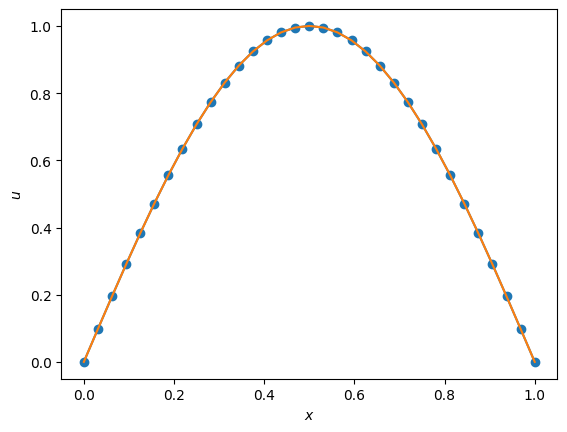

In [14]:
K_csr = K.tocsr()
u = scipy.sparse.linalg.spsolve(K_csr, f)

plt.plot(mesh.geometry, u, "o-")
plt.plot(mesh.geometry, np.sin(c * mesh.geometry), "-")
plt.xlabel(r"$x$")
plt.ylabel(r"$u$")
plt.show()

## Further exercises

### Exercise 8

Make a new function `cell_stiffness_quadrature` to compute the stiffness
matrix using a quadrature approach. Comment on the necessary order of the
quadrature rule to exactly compute the integrand. Pass this up to your
assembler and re-run, making sure you get the same result.


In [15]:
def cell_stiffness_quadrature(a: float, b: float) -> npt.NDArray[np.float64]:
    """Calculate the quadrature stiffness matrix contribution for a cell with vertices a and b.

    Args:
        a: Position of first vertex.
        b: Position of second vertex.

    Return:
        The stiffness matrix contribution for the cell.
    """
    assert b > a
    h = b - a

    # Initialize stiffness matrix
    A = np.zeros((2, 2), dtype=np.float64)

    # Derivatives of basis functions in reference element
    # For 1D linear elements these are constant:
    # dϕ₀/dx̂ = -1, dϕ₁/dx̂ = 1
    dphi_hat = np.array([-1.0, 1.0], dtype=np.float64)

    # Use quadrature to approximate the integral
    for point, weight in zip(quadrature_points, quadrature_weights):
        # For each combination of basis functions
        for i in range(2):
            for j in range(2):
                # Add contribution at this quadrature point
                # The 1/h factor comes from the chain rule when transforming derivatives
                A[i, j] += weight * dphi_hat[i] * dphi_hat[j] / h

    return A

### Exercise 10

Write a function `solve` which takes the `num_cells` (number of cells) as an
argument. Return the solution from the function. Plot a sequence of solutions
on increasingly fine meshes.


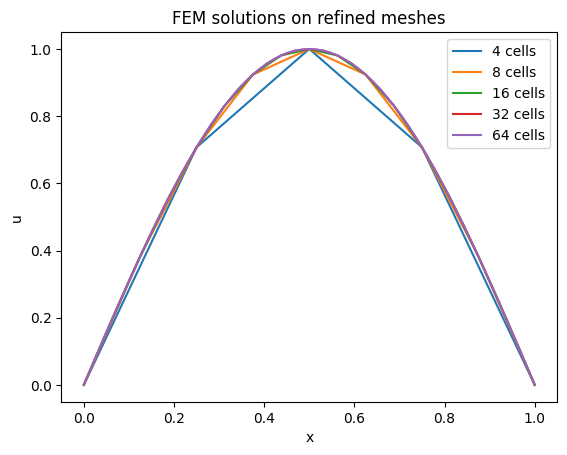

In [16]:

def solve(num_cells: int):
    mesh = create_unit_interval_mesh(num_cells)  # however your mesh is built
    fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])

    K = assemble_stiffness(fs, cell_stiffness_quadrature)  # or analytic
    f = assemble_load(fs, cell_load)

    boundary_dofs = np.array([0, mesh.geometry.shape[0] - 1], dtype=np.int32)
    apply_boundary_conditions(boundary_dofs, K, f)

    K_csr = K.tocsr()
    u_h = scipy.sparse.linalg.spsolve(K_csr, f)

    return mesh.geometry, u_h

for N in [4, 8, 16, 32, 64]:
    x, u = solve(N)
    plt.plot(x, u, label=f"{N} cells")

plt.legend()
plt.title("FEM solutions on refined meshes")
plt.xlabel("x")
plt.ylabel("u")
plt.show()

### Exercise 11

Modify the `solve` function to additionally return the error between the
interpolant of the solution and the solution in the natural norm.

$$
e_h = \lVert I_h u - u_h \rVert^2_{H^1_0} = (\mathbf{u} - \mathbf{u}_h)^T \mathbf{K} (\mathbf{u} - \mathbf{u}_h)
$$

where $\mathbf{u}$ is the vector of coefficients of the interpolant of the
exact solution $u$.

On a sequence of refined meshes compute the associated error. Plot the error
$e_h$ against $h$ on a log-log plot, and calculate the slope. What do you
observe?

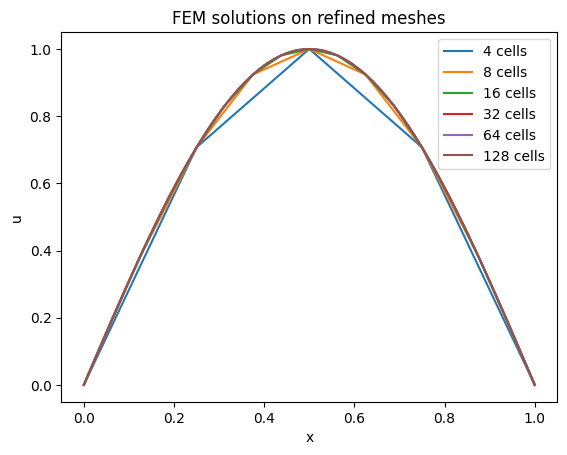

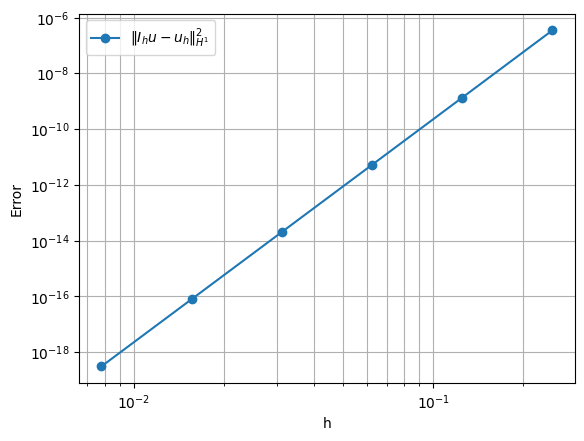

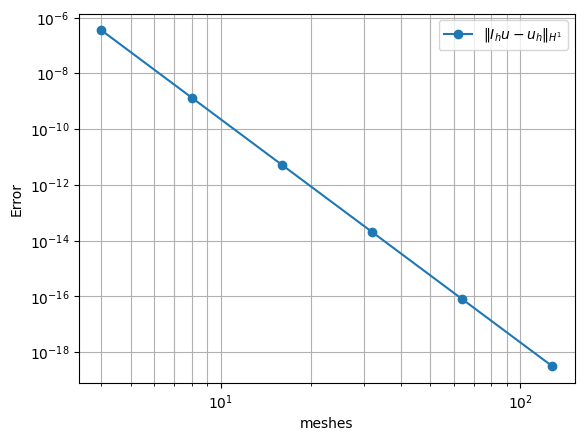

In [32]:
def u_exact(x: float) -> float:
    return np.sin(c * x)

def solve(num_cells: int, return_error: bool = False):
    mesh = create_unit_interval_mesh(num_cells)  # however your mesh is built
    fs =  FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])

    K = assemble_stiffness(fs, cell_stiffness_quadrature)  # or analytic
    f = assemble_load(fs, cell_load)

    boundary_dofs = np.array([0, mesh.geometry.shape[0] - 1], dtype=np.int32)
    apply_boundary_conditions(boundary_dofs, K, f)

    K_csr = K.tocsr()
    u_h = scipy.sparse.linalg.spsolve(K_csr, f)
    x = mesh.geometry.flatten()
    if return_error:
        u_e = u_exact(x)
        e = u_e - u_h
        error = e @ (K_csr.dot(e))
        return x, u_h, error

    return x, u_h, 0

# Example: plot solutions on refined meshes
meshes = [4, 8, 16, 32, 64, 128]
plt.figure()
for N in meshes:
    x, u, _ = solve(N)
    plt.plot(x, u, label=f"{N} cells")
plt.legend()
plt.title("FEM solutions on refined meshes")
plt.xlabel("x"); plt.ylabel("u")
plt.show()


# Compute and plot error vs meshes & error vs h
hs = []
errors = []
for N in meshes:
    h = 1.0 / N
    _, _, err = solve(N, return_error=True)
    hs.append(h)
    errors.append(err)

plt.figure()
plt.loglog(hs, errors, "o-", label=r"$\|I_hu - u_h\|_{H^1}^2$")
plt.xlabel("h"); plt.ylabel("Error")
plt.grid(True, which="both")
plt.legend()
plt.show()

plt.figure()  # Create a new figure for the error plot
plt.loglog(meshes, errors, "o-", label=r"$\| I_h u - u_h \|_{H^1}$")
plt.xlabel("meshes")
plt.ylabel("Error")
plt.grid(True, which="both")
plt.legend()